# Import and pre-definitions

In [1]:
import os
MAIN_PATH = r'/home/luis-felipe'
DATA_PATH = os.path.join(MAIN_PATH,'data')
PATH_MODELS = os.path.join(MAIN_PATH,'torch_models')
FIGS_PATH = os.path.join(MAIN_PATH,'results','figs')

In [2]:
import torch
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict

In [3]:
# Define o computador utilizado como cuda (gpu) se existir ou cpu caso contrário
print(torch.cuda.is_available())
dev = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
torch.set_default_dtype(torch.float64)
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)

True


In [4]:
import sys
sys.path.insert(1, '..')
sys.path.insert(1, '../..')

import models
from utils import measures,metrics
from data_utils import upload_logits,split_data
import post_hoc

# All Models

In [5]:
DATASET = 'ImageNet'
VAL_SIZE = 0.1 #5000
SUB_VAL_SIZE = 0.2
METRIC = metrics.AURC
NUM_EXPERIMENTS = 10

In [6]:
gamma_list = torch.arange(-3,3,0.1)
def optimize_gamma_p(risk,logits,fallback = True,gamma_list = gamma_list):
    naurc_min = METRIC(measures.MSP(logits),risk) if fallback else torch.inf
    p_star = 'MSP'
    gamma_star = 0
    for p in torch.arange(10):
        for gamma in gamma_list:
            naurc = METRIC(post_hoc.MaxLogit_pNorm(logits+gamma,p=p,centralize_logits=False),risk)
            if naurc < naurc_min:
                naurc_min = naurc
                p_star = p
                gamma_star = gamma
    return p_star,gamma_star

In [7]:
Gamma_fn = {'Raw':lambda x: 0,
            'Mean':lambda x: x.mean(-1).view(-1,1),
            'Min':lambda x: x.min(-1).values.view(-1,1),
            }

In [8]:
results = {Gamma:{0:defaultdict(list), 'opt': defaultdict(list)} for Gamma in Gamma_fn}
baseline = defaultdict(list)
acc = defaultdict(list)
means_logits = defaultdict(list)

In [9]:
seed = SEED
for i in range(NUM_EXPERIMENTS):
    print(i+1)
    for model_arc in models.list_models(DATASET):
        print(model_arc)
        with torch.no_grad():
            logits_val,labels_val,logits_test,labels_test = split_data.split_logits(*upload_logits(model_arc,DATASET,PATH_MODELS, 
                                split = 'test', device = dev),VAL_SIZE,seed = seed)
            logits_val,labels_val = logits_val[:int(SUB_VAL_SIZE*labels_val.size(0))],labels_val[:int(SUB_VAL_SIZE*labels_val.size(0))]
        risk_val = measures.wrong_class(logits_val,labels_val).float()
        risk_test = measures.wrong_class(logits_test,labels_test).float()
        acc[model_arc].append(1-risk_test.mean().item())
        baseline[model_arc].append(metrics.N_AURC(measures.MSP(logits_test),risk_test))
        means_logits[model_arc].append(logits_test.mean().item())

        for Gamma,fn in Gamma_fn.items():
            p,gamma = optimize_gamma_p(risk_val,logits_val-fn(logits_val))
            if p == 'MSP': results[Gamma]['opt'][model_arc].append(metrics.N_AURC(measures.MSP(logits_test),risk_test))
            else: results[Gamma]['opt'][model_arc].append(metrics.N_AURC(post_hoc.MaxLogit_pNorm(logits_test+gamma-fn(logits_test),p=p,centralize_logits=False),risk_test))
            p,gamma = optimize_gamma_p(risk_val,logits_val-fn(logits_val),gamma_list = [0])    
            if p == 'MSP': results[Gamma][0][model_arc].append(metrics.N_AURC(measures.MSP(logits_test),risk_test))
            else: results[Gamma][0][model_arc].append(metrics.N_AURC(post_hoc.MaxLogit_pNorm(logits_test-fn(logits_test),p=p,centralize_logits=False),risk_test))

    seed = seed+10

models_list = list(acc.keys())

1
alexnet
convnext_base
convnext_large
convnext_small
convnext_tiny
densenet121
densenet161
densenet169
densenet201
efficientnet_b0
efficientnet_b1
efficientnet_b2
efficientnet_b3
efficientnet_b4
efficientnet_b5
efficientnet_b6
efficientnet_b7
efficientnet_v2_l
efficientnet_v2_m
efficientnet_v2_s
googlenet
inception_v3
maxvit_t
mnasnet0_5
mnasnet0_75
mnasnet1_0
mnasnet1_3
mobilenet_v2
mobilenet_v3_large
mobilenet_v3_small
regnet_x_16gf
regnet_x_1_6gf
regnet_x_32gf
regnet_x_3_2gf
regnet_x_400mf
regnet_x_800mf
regnet_x_8gf
regnet_y_128gf
regnet_y_16gf
regnet_y_1_6gf
regnet_y_32gf
regnet_y_3_2gf
regnet_y_400mf
regnet_y_800mf
regnet_y_8gf
resnet101
resnet152
resnet18
resnet34
resnet50
resnext101_32x8d
resnext101_64x4d
resnext50_32x4d
shufflenet_v2_x0_5
shufflenet_v2_x1_0
shufflenet_v2_x1_5
shufflenet_v2_x2_0
squeezenet1_0
squeezenet1_1
swin_b
swin_s
swin_t
swin_v2_b
swin_v2_s
swin_v2_t
vgg11
vgg11_bn
vgg13
vgg13_bn
vgg16
vgg16_bn
vgg19
vgg19_bn
vit_b_16
vit_b_32
vit_h_14
vit_l_16
vit_l_32


In [10]:
means_gains = {Gamma:{0:{}, 'opt': {}} for Gamma in Gamma_fn}
std = {Gamma:{0:{}, 'opt': {}} for Gamma in Gamma_fn}
std_apg = {Gamma:{} for Gamma in Gamma_fn}
for Gamma in results:
    for gamma in results[Gamma]:
        for m,l in results[Gamma][gamma].items():
            means_gains[Gamma][gamma][m] = np.mean(post_hoc.significant(np.array(baseline[m])-np.array(l)))
            std[Gamma][gamma][m] = np.std(post_hoc.significant(np.array(baseline[m])-np.array(l)))
        std_apg[Gamma][gamma] = np.mean(post_hoc.significant(np.array(list(baseline.values()))-np.array(list(results[Gamma][gamma].values()))),0).std()

## Table 9

In [11]:
Gamma_to_str = {'Mean': r'$\mu(\mathbf{z})$', 'Min':'$\min_i z_i$', 'Raw':'0'}
for Gamma in Gamma_fn:
    string = Gamma_to_str[Gamma]
    for gamma,v in means_gains[Gamma].items():
        string += f" & {np.mean(list(v.values())):.5f}"+r' {\footnotesize $\pm$'+f"{std_apg[Gamma][gamma]:.5f}"+"}"
    print(string + r' \\')

0 & 0.06760 {\footnotesize $\pm$0.00077} & 0.06738 {\footnotesize $\pm$0.00091} \\
$\mu(\mathbf{z})$ & 0.06795 {\footnotesize $\pm$0.00077} & 0.06742 {\footnotesize $\pm$0.00093} \\
$\min_i z_i$ & 0.06626 {\footnotesize $\pm$0.00073} & 0.06523 {\footnotesize $\pm$0.00151} \\


## Figure 12

In [12]:
means_logits_means = np.array(list({m:np.mean(l) for m,l in means_logits.items()}.values()))
means_logits_std = np.array(list({m:np.std(l) for m,l in means_logits.items()}.values()))
gains_centralization = np.array(list({m:means_gains['Mean'][0][m]-means_gains['Raw'][0][m] for m in models_list}.values()))
gains_mlp = np.array(list(means_gains['Mean'][0].values()))

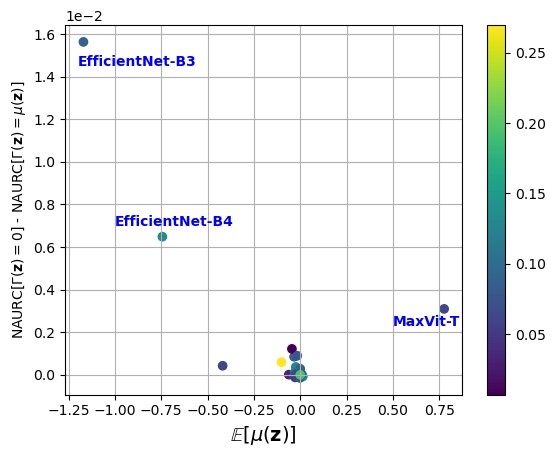

In [13]:


# Assuming your data arrays are defined as follows:
# means_logits_means, gains_mlp, gains_centralization, means_logits_std

# Mask to filter data based on gains_mlp condition
mask = gains_mlp > 0.0001

# Scatter plot with color mapped to gains_mlp
plt.scatter(means_logits_means[mask], gains_centralization[mask], c=gains_mlp[mask])

# Adding error bars for the x-axis
plt.errorbar(means_logits_means[mask], gains_centralization[mask], xerr=means_logits_std[mask], fmt='none', ecolor='gray', alpha=1)

# Annotating specific points
plt.text(-1.2, 0.0145, 'EfficientNet-B3', color='blue', weight="bold")
plt.text(-1, 0.007, 'EfficientNet-B4', color='blue', weight="bold")
plt.text(0.5, 0.0023, 'MaxVit-T', color='blue', weight="bold")

# Adding a colorbar
plt.colorbar()

# Adding grid, labels, and formatting
plt.grid()
plt.ylabel(r'NAURC[$\Gamma(\mathbf{z}) = 0$] - NAURC[$\Gamma(\mathbf{z}) = \mu(\mathbf{z})$]')
plt.xlabel(r'$\mathbb{E}[\mu(\mathbf{z})$]', fontsize = 14)
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0.1))

# Save the plot to a file
plt.savefig(os.path.join(FIGS_PATH, f'LogitsMean_centralizationgain_{DATASET}.pdf'), transparent=True, format='pdf', bbox_inches='tight')

# Show the plot
plt.show()


# Evaluate logits and metrics for one model

## Evaluate

In [14]:
MODEL = 'efficientnet_b3'#'efficientnet_b3' 
DATASET = 'ImageNet'
VAL_SIZE = 0.1 #5000
METRIC_opt = metrics.AURC
METRIC_plt = metrics.N_AURC
gamma_list = np.arange(-3,3,0.1)

In [15]:
logits_val,labels_val,logits_test,labels_test = split_data.split_logits(*upload_logits(MODEL,DATASET,PATH_MODELS, 
                            split = 'test', device = dev),VAL_SIZE,SEED)
risk_val = measures.wrong_class(logits_val,labels_val).float()
risk_test = measures.wrong_class(logits_test,labels_test).float()

In [16]:
p,gamma = optimize_gamma_p(risk_val,post_hoc.centralize(logits_val),gamma_list = [0])
T = post_hoc.optimize.T(logits_val,risk_val)

In [17]:
logits_test.mean()

tensor(-1.1697, device='cuda:0')

In [18]:
def div_max(x:torch.tensor):
    return torch.nn.functional.normalize(x,p=torch.inf,dim=-1)

## Plot

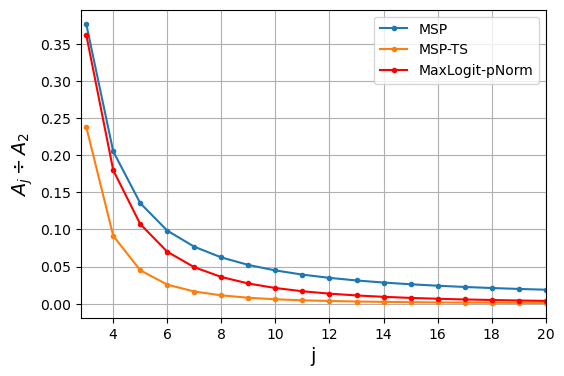

In [19]:
fig = plt.figure(figsize=(6,4))
sorted_logits = logits_test.sort(-1,descending=True).values
plt.plot(range(3,1001),div_max((sorted_logits-sorted_logits[:,:1]).div(1).exp().mean(0).cpu()[1:])[1:],'.-',label = r'MSP')
plt.plot(range(3,1001),div_max((sorted_logits-sorted_logits[:,:1]).div(T).exp().mean(0).cpu()[1:])[1:],'.-',label = r'MSP-TS')
plt.plot(range(3,1001),div_max(post_hoc.centralize(sorted_logits).div(post_hoc.centralize(sorted_logits)[:,:1]).abs().pow(p).mean(0).cpu()[1:])[1:],'.-', label = r'MaxLogit-pNorm', color = 'red')
#plt.plot(range(2,1001),div_max(sorted_logits.div(sorted_logits[:,:1]).abs().pow(p).mean(0).cpu()[1:]), label = r'$p$-norm-NC')
plt.grid()
#plt.ylim(0,0.4)
#plt.xlim(800,right=1000)
plt.xlim(2.8,right=20)
plt.ylabel(r'$A_j \div A_2$', fontsize = 14)
plt.xlabel('j', fontsize = 14)
plt.legend()
plt.savefig(os.path.join(FIGS_PATH, f'fj_f2_20_{MODEL}.pdf'), transparent = True, format = 'pdf',bbox_inches = 'tight')
plt.show()

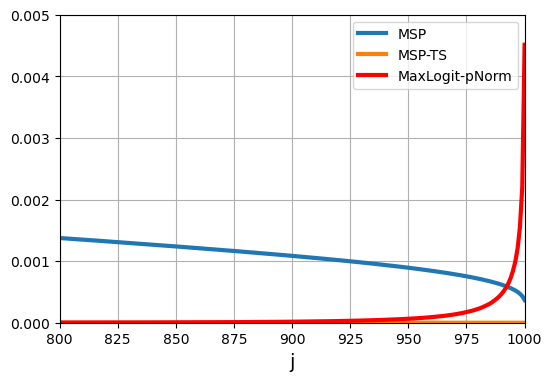

In [20]:
fig = plt.figure(figsize=(6,4))
fig.tight_layout()
sorted_logits = logits_test.sort(-1,descending=True).values
plt.plot(range(3,1001),div_max((sorted_logits-sorted_logits[:,:1]).div(1).exp().mean(0).cpu()[1:])[1:],label = r'MSP',linewidth = 3)
plt.plot(range(3,1001),div_max((sorted_logits-sorted_logits[:,:1]).div(T).exp().mean(0).cpu()[1:])[1:],label = r'MSP-TS',linewidth = 3)
plt.plot(range(3,1001),div_max(post_hoc.centralize(sorted_logits).div(post_hoc.centralize(sorted_logits)[:,:1]).abs().pow(p).mean(0).cpu()[1:])[1:], label = r'MaxLogit-pNorm', color = 'red',linewidth = 3)
#plt.plot(range(2,1001),div_max(sorted_logits.div(sorted_logits[:,:1]).abs().pow(p).mean(0).cpu()[1:]), label = r'$p$-norm-NC')
plt.grid()
plt.ylim(0,0.005)
plt.xlim(800,right=1000)
#plt.xlim(2.8,right=20)
#plt.ylabel(r'$A_j \div A_2$')
plt.xlabel('j', fontsize = 14)
plt.legend()
plt.savefig(os.path.join(FIGS_PATH, f'fj_f2_800_{MODEL}.pdf'), transparent = True, format = 'pdf',bbox_inches = 'tight')
plt.show()

$\sum_{j>100} A_j$

In [21]:
print('MSP: ', div_max((sorted_logits-sorted_logits[:,:1]).div(1).exp().mean(0).cpu()[1:])[100:].sum().item())
print('MSP-TS: ', div_max((sorted_logits-sorted_logits[:,:1]).div(T).exp().mean(0).cpu()[1:])[100:].sum().item())
print('MaxLogit-pNorm: ', div_max(post_hoc.centralize(sorted_logits).div(post_hoc.centralize(sorted_logits)[:,:1]).abs().pow(p).mean(0).cpu()[1:])[100:].sum().item())

MSP:  2.020102519019587
MSP-TS:  0.005089114284009764
MaxLogit-pNorm:  0.023908200739240108
